### 1. Bibliotecas

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from mpl_toolkits import mplot3d

from IPython import display

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.tree import export_graphviz

from pandas.plotting import scatter_matrix

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 2. Import do Dataset

In [37]:
col_names = ['Class', 'Specimen_Number', 'Eccentricity',
             'Aspect_Radio', 'Elongation', 'Solidity',
             'Stochastic_Convexity', 'Isoperimetric_Factor', 'Maximal_Identation_Depth',
             'Lobedness', 'Average_Intensity', 'Average_Contrast', 'Smoothness',
             'Third_Moment', 'Uniformity', 'Entropy']

df = pd.read_csv('dados/leaf.csv', header=None, names=col_names)
#df = pd.read_csv('dados/leaf.csv', header=None)

In [38]:
df.head()

,Class,Specimen_Number,Eccentricity,Aspect_Radio,Elongation,Solidity,Stochastic_Convexity,Isoperimetric_Factor,Maximal_Identation_Depth,Lobedness,Average_Intensity,Average_Contrast,Smoothness,Third_Moment,Uniformity,Entropy
0,1,1,0.72694,1.4742,0.32396,0.98535,1.00000,0.83592,0.004657,0.003947,0.047790,0.127950,0.016108,0.005232,0.000275,1.17560
1,1,2,0.74173,1.5257,0.36116,0.98152,0.99825,0.79867,0.005242,0.005002,0.024160,0.090476,0.008119,0.002708,0.000075,0.69659
2,1,3,0.76722,1.5725,0.38998,0.97755,1.00000,0.80812,0.007457,0.010121,0.011897,0.057445,0.003289,0.000921,0.000038,0.44348
3,1,4,0.73797,1.4597,0.35376,0.97566,1.00000,0.81697,0.006877,0.008607,0.015950,0.065491,0.004271,0.001154,0.000066,0.58785
4,1,5,0.82301,1.7707,0.44462,0.97698,1.00000,0.75493,0.007428,0.010042,0.007938,0.045339,0.002051,0.000560,0.000024,0.34214


In [39]:
X = df.iloc[:, 2:] # 14 feature columns
y = df.iloc[:, 0]  # 1 class column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 3. Visualização dos Dados

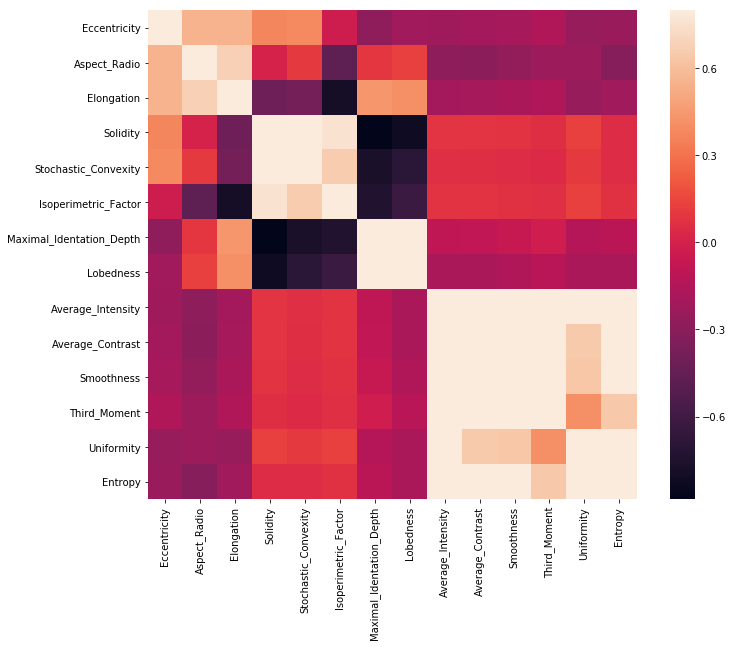

In [40]:
#correlation matrix
corrmat = X.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns_plot = sns.heatmap(corrmat, vmax=.8, square=True)
plt.savefig('corr-map.png')

## 4. Treinamento do Modelo

In [7]:
rfc = RandomForestClassifier(random_state=42)

# Dictionary with parameters names (string) as keys and lists of parameter settings to try as values,
# or a list of such dictionaries, in which case the grids spanned by each dictionary in the list are explored.
# This enables searching over any sequence of parameter settings.

max_depth = [2, 5, 8, 10, 15, 18, 20, 24, 30]
max_depth.append(None)

param_grid = {
    # The number of trees in the forest
    'n_estimators': [10, 15, 25, 50, 100, 150, 200, 250, 300],
    
    # The function to measure the quality of a split
    'criterion' :['gini', 'entropy'],
    
    # The maximum depth of the tree
    'max_depth' : max_depth,
    
    # The number of features to consider when looking for the best split
    'max_features': ['sqrt', 'log2']
}

#scoring = ['accuracy', 'f1_micro', 'f1_macro']
scoring = ['accuracy']

CV_rfc = GridSearchCV(estimator=rfc,
                      scoring=scoring,
                      n_jobs=-1, # Number of jobs to run in parallel (-1 == All)
                      param_grid=param_grid,
                      verbose=True,
                      refit='accuracy',
                      cv=10, # 10-Fold Cross-Validation
                      return_train_score=True)

CV_rfc.fit(X_train, y_train)

df2 = pd.DataFrame(CV_rfc.cv_results_)
df2.to_csv('resultado.csv', sep=';')

Fitting 10 folds for each of 360 candidates, totalling 3600 fits


C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 516 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 994 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1569 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2279 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 2929 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:  6.0min finished
C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True t

In [41]:
# Get top and bottom parameters 
sorted_df = df2.sort_values('rank_test_accuracy').loc[:,['param_criterion', 'param_max_depth', 'param_max_features', 'param_n_estimators','mean_fit_time', 'mean_score_time', 'mean_test_accuracy', 'mean_train_accuracy']]
sorted_df.columns = ['Criterion ', 'Max depth', 'Max features', 'N estimators','Fit time', 'Score time', 'Test accuracy', 'Train accuracy']
top = 3; bottom = 3
top_params = sorted_df.iloc[:top,:]
bottom_params = sorted_df.iloc[-bottom:,:]
print('Top {} parameters:\n{}'.format(top, top_params))
print('Bottom {} parameters:\n{}'.format(top, bottom_params))
top_params.iloc[:,:4].to_csv('topParams.csv', sep=';', index=False, float_format='%.4f')
top_params.iloc[:,4:].to_csv('topScores.csv', sep=';', index=False, float_format='%.4f')
bottom_params.iloc[:,:4].to_csv('bottomParams.csv', sep=';', index=False, float_format='%.4f')
bottom_params.iloc[:,4:].to_csv('bottomScores.csv', sep=';', index=False, float_format='%.4f')

Top 3 parameters:
    Criterion  Max depth Max features N estimators  Fit time  Score time  \
105       gini        18         log2          200  0.440113    0.029721   
141       gini        24         log2          200  0.418297    0.023717   
96        gini        18         sqrt          200  0.417096    0.025918   

     Test accuracy  Train accuracy  
105       0.790441             1.0  
141       0.790441             1.0  
96        0.790441             1.0  
Bottom 3 parameters:
    Criterion  Max depth Max features N estimators  Fit time  Score time  \
189    entropy         2         log2           10  0.025818    0.002302   
180    entropy         2         sqrt           10  0.030722    0.002302   
0         gini         2         sqrt           10  0.042531    0.007404   

     Test accuracy  Train accuracy  
189       0.341912        0.421246  
180       0.341912        0.421246  
0         0.341912        0.463985  


In [42]:
# Get the best parameters
print ('Best parameters:', CV_rfc.best_params_)
print ('Best Score:', CV_rfc.best_score_)
print ('Best Score Time:', CV_rfc.refit_time_)

Best parameters: {'criterion': 'gini', 'max_depth': 18, 'max_features': 'sqrt', 'n_estimators': 200}
Best Score: 0.7904411764705882
Best Score Time: 0.34224557876586914


In [51]:
# Construct model with the best parameters values
rfc1=RandomForestClassifier(random_state=42,
                            max_features='sqrt',
                            n_estimators= 200,
                            max_depth=18,
                            criterion='gini')
# Fit the data
rfc1.fit(X_train, y_train)

# Predict
y_pred=rfc1.predict(X_test)

# Show classification report
print(classification_report(y_test, y_pred, digits=4))
# Show accuracy score test data
print(accuracy_score(y_test, y_pred))
# Show accuracy score train data
print(accuracy_score(y_train, rfc1.predict(X_train)))

              precision    recall  f1-score   support

           1     0.5000    0.6667    0.5714         3
           2     1.0000    1.0000    1.0000         1
           3     0.0000    0.0000    0.0000         1
           4     0.0000    0.0000    0.0000         2
           5     1.0000    1.0000    1.0000         3
           6     1.0000    1.0000    1.0000         2
           7     0.5000    1.0000    0.6667         1
           8     1.0000    1.0000    1.0000         5
           9     0.6667    0.6667    0.6667         3
          10     0.5000    1.0000    0.6667         1
          11     1.0000    1.0000    1.0000         7
          12     1.0000    0.5000    0.6667         2
          13     0.3333    0.5000    0.4000         2
          14     1.0000    0.5000    0.6667         2
          15     1.0000    1.0000    1.0000         1
          22     0.8000    0.8000    0.8000         5
          24     1.0000    1.0000    1.0000         2
          25     1.0000    

C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetri

## 5. Visualização dos Resultados

C:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
C:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


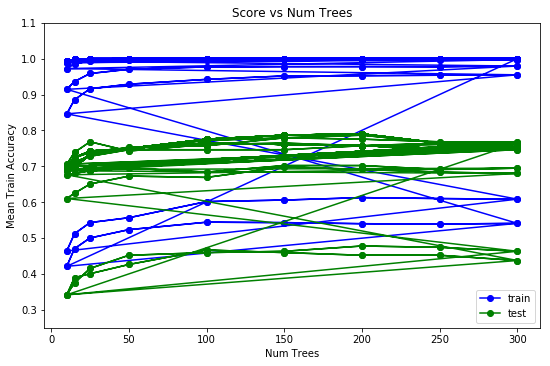

In [52]:
def plot_results(model, param = 'n_estimators', name = 'Num Trees'):
    param_name = 'param_%s' % param

    # Extract information from the cross validation model
    train_scores = model.cv_results_['mean_train_accuracy']
    test_scores = model.cv_results_['mean_test_accuracy']
    train_time = model.cv_results_['mean_fit_time']
    param_values = list(model.cv_results_[param_name])
    
    # Plot the scores over the parameter
    plt.subplots(figsize=(16, 6))
    #plt.subplots(1, 2, figsize=(16, 6))
    plt.subplot(121)
    plt.plot(param_values, train_scores, 'bo-', label = 'train')
    plt.plot(param_values, test_scores, 'go-', label = 'test')
    plt.ylim(ymin = 0.25, ymax = 1.1)
    plt.legend()
    plt.xlabel(name)
    plt.ylabel('Mean Train Accuracy')
    plt.title('Score vs %s' % name)
    
    #plt.subplot(122)
    #plt.plot(param_values, train_time, 'ro-')
    #plt.ylim(ymin = 0.0, ymax = 2.0)
    #plt.xlabel(name)
    #plt.ylabel('Train Time (sec)')
    #plt.title('Training Time vs %s' % name)
    
    plt.savefig('full_figure.png')
    plt.tight_layout(pad = 4)
    
plot_results(CV_rfc)

C:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
C:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


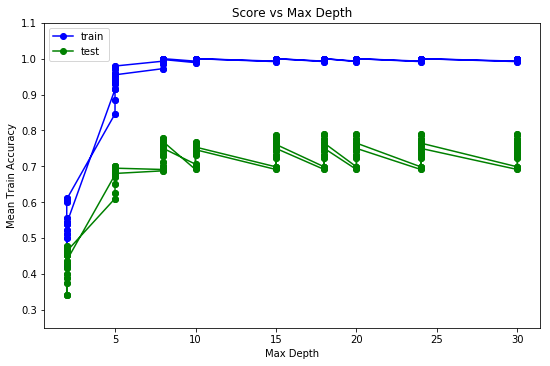

In [53]:
plot_results(CV_rfc, param='max_depth', name = 'Max Depth')

In [54]:
# Plot do trab. anterior não funciona bem com 40 classes
cm = confusion_matrix(y_test,y_pred)

classes = ['Quercus_suber','Salix_atrocinera','Populus_nigra','Alnus_sp.','Quercus_robur',
          'Crataegus_monogyna','Ilex_aquifolium','Nerium_oleander','Betula_pubescens', 'Tilia tomentosa',
          'Acer_palmatum', 'Celtis_sp.', 'Corylus_avellana','Castanea_sativa','Populus_alba',
          'Acer_negundo','Taxus_bacatta','Papaver_sp.','Polypolium_vulgare','Pinus_sp.',
          'Fraxinus_sp.','Primula_vulgaris','Erodium_sp.','Bougainvillea_sp.','Arisarum_vulgare',
          'Euonymus_japonicus','Ilex_perado_ssp._azorica','Magnolia_soulangeana','Buxus_sempervirens','Urtica_dioica',
          'Podocarpus_sp.','Acca_sellowiana','Hydrangea_sp.','Pseudosasa_japonica','Magnolia_grandiora',
           'Geranium_sp.','Aesculus_californica','Chelidonium_majus',
           'Schinus_terebinthifolius','Fragaria_vesca']

print (cm)

[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 

In [55]:
str_tree = export_graphviz(rfc1.estimators_[0], 
   out_file='tree.dot', 
   feature_names=X_train.columns, # column names
   class_names=classes)

#os.system('dot -Tpng tree.dot -o tree.png')
# Display in jupyter notebook
#from IPython.display import Image
#Image(filename = 'tree.png')

In [56]:
# Use pydot for converting to an image file
import pydot

# Import the dot file to a graph and then convert to a png
(graph, ) = pydot.graph_from_dot_file('imgs/tree.dot')
graph.write_png('imgs/tree.png')

FileNotFoundError: [Errno 2] No such file or directory: 'imgs/tree.dot'

---